


# Análise exploratória de dados do Titanic

## Resumo
---
 
 [Introdução](#Introdução)

 [Conjunto de dados](#Conjunto-de-dados)
 
 [Ferramentas](#Ferramentas)

 [Questões-chave](#Questões-chave)

 [Considerações finais](#Considerações-finais)

 [Referências](#Referências)

 # Introdução
A tragégia no naufrágio do Navio Titanic muito retratado em ...

# Ferramentas

Para análise foi utilizada a linguagem Python e suas bibliotecas: **pandas** para estrutura e manipulação de dados; **numpy** para operação com matrizes e vertores; **matplotlib** e **seaborn** para visualização de dados; **funções personalizadas** para manipulação dos dados; **formatação de tabela** personalizada para aprimorar a exibição dos dados.

In [1]:
# bibliotecas usadas para análise
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')

# bibliotecas complementares para análise
from data.data_modules import data_manipulation_functions as dm
from data.data_modules import data_plot_functions as pf
from data.data_modules import data_table_format as tab
from data.data_modules import data_styles_main as st

# Conjunto de dados

#### Fonte
A análise foi feita com os dados fornecidos pela Udacity a partir de uma amostra do site Kaggle.  
Para mais detalhes, esse é o link para a fonte dos dados https://www.kaggle.com/c/titanic/data

#### Preparação dos dados
Para deixar os dados mais legíveis e consistentes de modo a preservar a informação, os dados passaram por um processo de limpeza. Durante a execução, algumas colunas foram avaliadas com relação à qualidade e pertinência de serem utilizadas na análise. Assim, dentre as 12 colunas foram delimitadas as seguintes 10 colunas:

- **survived** (informa se sobreviveu)
- **ticket_class** (classe da passagem)
- **name** (nome)
- **gender** (sexo)
- **age** (idade)
- **siblings_or_spouses** (quantidade de irmãs(ãos) ou  cônjuges)
- **parents_or_children** (quantidade de pais ou filhas(os))
- **ticket_number** (número do bilhete)
- **fare** (tarifa paga) 
- **embarkation_city** (cidade de embarque)

Dentre as colunas, a que contém os dados referentes a idade possuia cerca de 80% dos dados completos. Para permitir cruzamentos entre outras variáveis, os cerca de 20% de dados foram preenchidos de modo randômico de modo a preservar a proporção de diferençãs de idade dos dados completos.

O passo a passo realizado pode ser verificado em [/data/data_wrangling.ipynb](./data/data_wrangling.ipynb)

In [2]:
# carregamento dos dados
data_titanic = pd.read_csv('./data/data_titanic_clean')

# exibição das 3 primeiras linhas do conjunto de dados
tab.format_table(data_titanic.head(10))

,name,age,gender,ticket_class,fare,ticket_number,embarkation_city,siblings_or_spouses,parents_or_children,survived
0,"Braund, Mr. Owen Harris",22,male,third,7.25,A/5 21171,Southampton,1,0,no
1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",38,female,first,71.2833,PC 17599,Cherbourg,1,0,yes
2,"Heikkinen, Miss. Laina",26,female,third,7.925,STON/O2. 3101282,Southampton,0,0,yes
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35,female,first,53.1,113803,Southampton,1,0,yes
4,"Allen, Mr. William Henry",35,male,third,8.05,373450,Southampton,0,0,no
5,"Moran, Mr. James",20.9,male,third,8.4583,330877,Queestown,0,0,no
6,"McCarthy, Mr. Timothy J",54,male,first,51.8625,17463,Southampton,0,0,no
7,"Palsson, Master. Gosta Leonard",2,male,third,21.075,349909,Southampton,3,1,no
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27,female,third,11.1333,347742,Southampton,0,2,yes
9,"Nasser, Mrs. Nicholas (Adele Achem)",14,female,second,30.0708,237736,Cherbourg,1,0,yes


Além do conjunto de dados a partir da preparação, no decorrer da análise, novas combinações entre os dados foram realizadas conforme podem ser conferidas abaixo: 

In [44]:
# mediana que divide os valores pagoso pela primeira classe
first_class_median_fare = data_titanic.query('ticket_class == "first"')['fare'].median()

# destino das pessoas
survivors = data_titanic.query('survived == "yes"')
victims = data_titanic.query('survived == "no"')

# viajantes sós vs acompanhados
alone = data_titanic.query('siblings_or_spouses == 0 and parents_or_children == 0')
group = data_titanic.query('siblings_or_spouses != 0 and parents_or_children != 0')
data_titanic['companion'] = pd.DataFrame({'companion':['alone']*len(alone.index)}, index=alone.index)
data_titanic['companion'].fillna('group', inplace=True)

# embarque
embarkation_cities = data_titanic.query('embarkation_city != "not_provided"')

# idade
data_titanic['maturity'] = data_titanic['age'].apply(lambda age: 'adult' if age < 18 else 'child')
adults = data_titanic.query('age > 18')
kids = data_titanic.query('age <= 18')

# cruzamentos entre conjunto de dados
companion_x_destiny = pd.crosstab(data_titanic['companion'], data_titanic['survived'], normalize='all')
class_cities_mean_fare = pd.crosstab(index=data_titanic['ticket_class'], margins='all',\
                                     columns=data_titanic['embarkation_city'],\
                                     values=data_titanic['fare'], aggfunc='mean')
class_cities_mean_fare = class_cities_mean_fare[['Southampton', 'Cherbourg', 'Queestown']]
max_city_mean_ticket = max(class_cities_mean_fare.describe().max())

class_cities_mean_survivors = pd.crosstab(index=survivors['ticket_class'], margins='all',\
                                          columns=embarkation_cities['embarkation_city'],\
                                          values=survivors['survived'], aggfunc='count')
class_cities_mean_survivors = class_cities_mean_survivors[['Southampton', 'Cherbourg', 'Queestown']]
class_cities_mean_survivors_max = max(class_cities_mean_survivors.loc['All':].describe().max())

class_cities_mean_victims = pd.crosstab(index=victims['ticket_class'], margins='all',
                                        columns=embarkation_cities['embarkation_city'],\
                                        values=victims['survived'], aggfunc='count')
class_cities_mean_victims = class_cities_mean_victims[['Southampton', 'Cherbourg', 'Queestown']]
class_cities_mean_victims_max = max(class_cities_mean_victims.loc['All':].describe().max())

class_cities_mean_survivors_victims_max = max(class_cities_mean_survivors_max, class_cities_mean_victims_max)

#### Descrição da amostra
A amostra contém **891** dados que representam cerca de **20%** da quantidade total de **2224** referentes às pessoas presentes no navio. Por possuir apenas informações sobre a classe do tipo de passagem comprada, podemos inferir que essa **amostra é delimitada aos passageiros** do navio o que deixa de fora, assim, informações sobre a tripulação.

# Questões-chave
A investigação feita buscou focar em temas relacionados a idade, gênero e econômico a partir da amostra de dados do Titanic. Para chegar às questões da análise, primeiramente foram elaboradas algumas questões iniciais (1 e 2) antes da limpeza dos dados e uma outra questão(3) depois.
Assim, como resultado, as seguintes questões-chave foram elencadas:

#### Questões
1. Pessoas com maior poder aquisitivo também foram as que mais sobreviveram à tragédia?
- É possível confirmar o ditado de que mulheres e crianças são prioridade no salvamento dentre as pessoas passageiras?
- Pessoas que viajaram sozinhas tiveram mais chances de sobreviver?

### 1. Pessoas com maior poder aquisitivo também foram as que mais sobreviveram à tragédia?

Há duas variáveis no conjunto de dados que indicam poder aquisitivo: **ticket_class**(classe da passagem) e  **fare** (tarifa paga). Ambas ficam restritas ao contexto da viagem e outros bens como imóveis ou heranças não foram informados. Para efeito da análise, vamos considerar, principalmente, pessoas com alto poder aquisitivo àquelas da primeira classe e com alto valor de tarifa pago e pessoas com baixo poder aquisitivo o contrário.

#### Classes
A classe das passagens é dividida em 3 tipos que, a princípio, sugerem ser da mais cara para mais barata: primeira, segunda e terceira. Por si só já seria um critério que aponta, no geral, para o poder aquisitivo da pessoa. No entanto precisamos considerar que há casos de descontos da passagem (até mesmo não pagamento).

In [4]:
# quantidade de pessoas que não pagaram por classe de passagem
pd.crosstab(data_titanic.query('fare == 0')['fare'], data_titanic['ticket_class']).to_dict()

{'first': {0.0: 5}, 'second': {0.0: 6}, 'third': {0.0: 4}}

Dada a sugestão inicial, há de fato uma correspondência entre tipo de classe e valor pago na tarifa de fato nessa amostra?

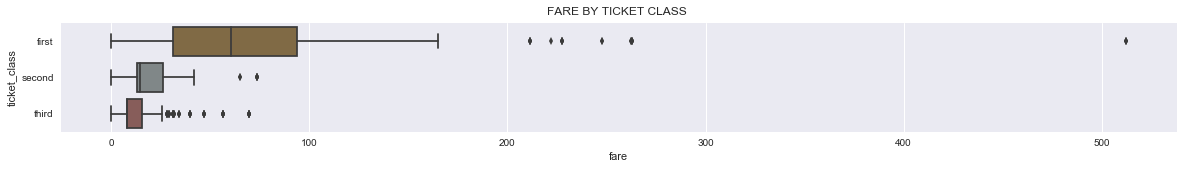

In [5]:
figure, ax = plt.subplots(1,1, figsize=(20,2))
# ----------------------------------------------------------------------------------------------------
fare_ticket_class = sns.boxplot(y='ticket_class', x='fare', data=data_titanic,\
            palette=st.palette_classes, order=['first', 'second', 'third'])
pf.set_title(fare_ticket_class, 'Fare by ticket class ')
# ----------------------------------------------------------------------------------------------------
figure.show()

Por meio da gráfico podemos confirmar que sim os valores da tarifa correspondem no geral, com exceção de alguns outliers (valores com anomalia em relação ao todo), ao tipo de classe de passagem: da primeira com tarifa maior até a terceira com tarifa menor.

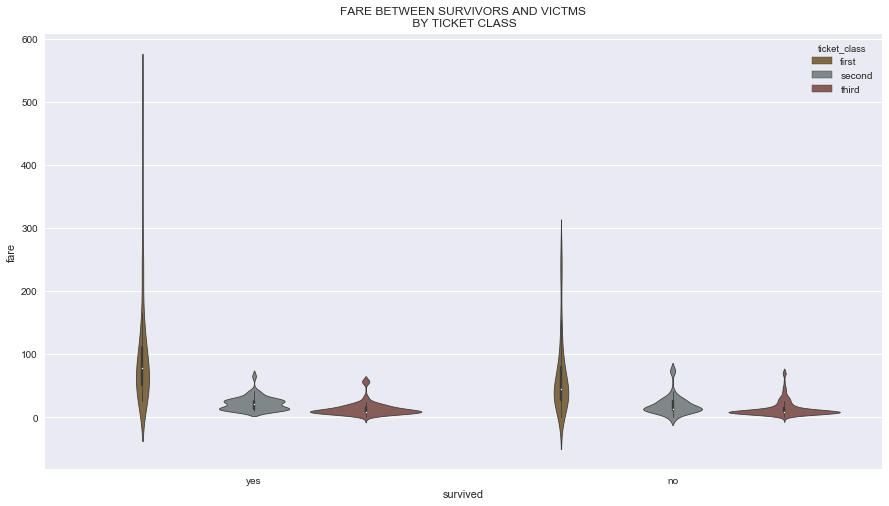

In [6]:
figure, ax = plt.subplots(1,1, sharex='col', sharey='row', figsize=(15,8))
# ----------------------------------------------------------------------------------------------------
fare_ticket_class_destiny = sns.violinplot(x='survived', y='fare', order=['yes','no'], data=data_titanic,\
                                   hue_order=['first','second','third'], hue='ticket_class',\
                                   palette=st.palette_classes, linewidth=0.8 )
pf.set_title(fare_ticket_class_destiny, 'Fare between survivors and victms\n by ticket class')
# ----------------------------------------------------------------------------------------------------
figure.show()

Acima comparamos as pessoas que sobreviveram e morreram com as classes delas. Podemos destacar, por meio das distribuições, que mais pessoas da primera classe e que pagaram mais sobreviveram.

#### Tarifas
A tarifa paga do conjunto de dados não deixa claro sobre o que exatamento foi pago: passagem? taxa de embarque? serviços extras? Vamos levar em conta, para análise, que pelo pelo menos o valor da passagem.

In [46]:
# mediana
total_above_median = data_titanic.query(f'fare >= {first_class_median_fare}')['fare'].count()
survivors_above_median = survivors.query(f'fare >= {first_class_median_fare}')['fare'].count()
victims_above_median = victims.query('fare >= 62.3')['fare'].count()

survivors_above_medium_percentage = dm.get_percent_of(survivors_above_median, total_above_median)
victims_above_medium_percentage = dm.get_percent_of(victims_above_median, total_above_median)

print(f'survivors_above_medium_percentage: {survivors_above_medium_percentage}%',
      f'\nvictims_above_medium_percentage: {victims_above_medium_percentage}%')

survivors_above_medium_percentage: 67.21311475409836% 
victims_above_medium_percentage: 30.327868852459016%


In [ ]:
figure, ax = plt.subplots(1,2, sharex='col', sharey='row', figsize=(20,5))
# ----------------------------------------------------------------------------------------------------
fare_survivors = pf.plot_distribution_with_means(survivors['fare'], color=st.color_survivors,\
                                                 title='Survivors fare distributions', ax=ax[0])

fare_victims = pf.plot_distribution_with_means(victims['fare'], color=st.color_victims,\
                                               title='Victims fare distributions', ax=ax[1])
# ----------------------------------------------------------------------------------------------------
figure.show()

Por meio da distribuição dos valores das passagens acima, podemos observar a concentração dos valores pagos com relação aos sobreviventes e às vítimas. Disso, o que se destaca é a alta concentração de quantidade de vítimas que pagaram um valor baixo de passagem. 
A média geral do valor pago para viajar pelos sobreviventes é mais que o dobro do das vítimas. Além disso, 

Outro ponto importante é o valor médio das tarifas considerando a cidade de embarque. A rota seria sair da cidade Southampton, passar por Cherbourg, em seguida por Queestown e atravessar o oceano Atlântico até chegar em New York. Diferente do tipo de cobrança em que é mais caro conforme a distância percorrida do embarque ao destino, vemos pelo heatmap a seguir que, quem embarcou na segunda cidade Cherbourg, na mégia geral pagou mais caro.

In [ ]:
figure, ax = plt.subplots(1,2, figsize=(15,2.5))
# ----------------------------------------------------------------------------------------------------
cities_mean = sns.heatmap(class_cities_mean_fare.loc['All':], annot=True, fmt='.2f', cmap='BuPu',\
                          ax=ax[0], vmin=0, vmax=max_city_mean_ticket, cbar=False, linewidths=2)
pf.set_title(cities_mean, 'Mean fare by embarkation city')
cities_mean.set_xlabel('') and cities_mean.set_ylabel('')

cities_mean_cities = sns.heatmap(class_cities_mean_fare.drop('All'), annot=True, fmt='.2f', cmap='BuPu',\
                                 ax=ax[1], vmin=0, vmax=max_city_mean_ticket, cbar=False, linewidths=2)
pf.set_title(cities_mean_cities, 'Mean ticket class fare by embarkation city')
cities_mean_cities.set_xlabel('') and cities_mean_cities.set_ylabel('')
# ----------------------------------------------------------------------------------------------------
figure.show()

In [ ]:
figure, ax = plt.subplots(1,2, figsize=(15,2.5))
# ----------------------------------------------------------------------------------------------------
class_cities_mean_heatmap_survivors = sns.heatmap(class_cities_mean_survivors.drop(index='All'),\
                                                  annot=True, ax=ax[0], fmt='#', cbar=False,\
                                                  vmin=0,\
                                                  linewidths=2, cmap=sns.light_palette(st.color_survivors))
pf.set_title(class_cities_mean_heatmap_survivors, 'Mean class fare survivors by embarkation city')
class_cities_mean_heatmap_survivors.set_xlabel('') and class_cities_mean_heatmap_survivors.set_ylabel('')

class_cities_mean_heatmap_victims = sns.heatmap(class_cities_mean_victims.drop(index='All'), annot=True, ax=ax[1],\
                                                fmt='#', vmin=0, \
                                                cbar=False, linewidths=2, cmap=sns.light_palette(st.color_victims))
pf.set_title(class_cities_mean_heatmap_victims, 'Mean class fare victms by embarkation city')
class_cities_mean_heatmap_victims.set_xlabel('') and class_cities_mean_heatmap_victims.set_ylabel('')
# ----------------------------------------------------------------------------------------------------
figure.show()

A respeito da quantidade de sobreviventes por cidade de embarque a prevalência, no entanto, se deu na cidade de saída Southampton. Esta também possui uma quantidade de sobreviventes de várias classes mais equilibrado com cerca de **72** sobreviventes por classe.

#### Fechamento
De acordo com a amostra, confirmamos que existe uma relação direta entre classe e o valor pago. Essas duas variáveis foram usadas como critérios para informar se alguém tem um alto ou baixo pode aquisitivo.  
Não é possível afirmar o porquê mas pessoas passageiras com alto poder aquisitivo foram sim as que mais sobreviveram. Isso é reforçado pelo grande quantidade de pessoas da primeira classe sobrevivente com destaque para as pessoas com maior pagamento de tarifa. Em contraste, a maior concentração de vítimas é de pessoas da terceira classe. 

### 2. É possível confirmar o ditado de que mulheres e crianças são prioridade no salvamento dentre as pessoas passageiras?

critério de idade para adulto unicef

In [ ]:
sns.FacetGrid(adults, col='survived', hue='gender',\
              palette=st.palette_gender, height=3, aspect=2).map(sns.distplot, 'age', kde=False)
sns.FacetGrid(adults, col='survived', hue='maturity',\
              palette=st.palette_maturity, height=3, aspect=2).map(sns.distplot, 'age', kde=False)
# sns.catplot(x='survived', hue='maturity', data=data_titanic, kind='bar')

In [ ]:
pd.crosstab(index=data_titanic['gender'], columns=data_titanic['maturity'], margins=True, normalize='all')

>age >fare
>media considerando cada local de embarque tem valor diferente

### 3. Pessoas que viajaram sozinhas tiveram mais chances de sobreviver?

In [ ]:
companion_plot = sns.catplot(y='survived', hue='companion', kind='count', data=data_titanic, order=['yes','no'],\
                             palette=st.palette_companion, height=2, aspect=6)

In [ ]:
sns.heatmap(companion_x_destiny, annot=True, fmt='#%', cmap='BuPu')

# Considerações finais

Embora focada em passageiros


**Critérios**:
- "Faça testes e sugira perguntas que promovam olhar para relacionamentos entre múltiplas variáveis"
- "Você deve analisar pelo menos uma variável dependente e três variáveis ​​independentes em sua investigação"
- "Uma definição de qual pergunta você fez"
- "Uma nota especificando qual foi o conjunto de dados usado"
- "Uma descrição do que você fez para investigar a pergunta"
Um PDF ou HTML contendo sua análise. Este arquivo deve conter:


Descrição de qualquer limpeza de dados feita  
Um resumo das estatísticas e gráficos comunicando seu resultado final  
O código usado para criar suas análises. Se você usou um notebook iPython, pode enviar seu .ipynb. Caso não o tenha feito, encaminhe os arquivos .py.



Para obter maior compreensão dos dados, segue uma descrição... ?? 

### Referências

##### Fonte
- [Kaggle - Titanic](https://www.kaggle.com/c/titanic/data)

##### Conteúdos sobre Titanic:
- [Em naufrágios, crianças e mulheres têm mesmo prioridade?](https://super.abril.com.br/mundo-estranho/em-naufragios-criancas-e-mulheres-tem-mesmo-prioridade/)
- [Em naufrágios e outros desastres, mulheres e crianças só conseguem sair por último](http://revistagalileu.globo.com/Revista/Common/0,,EMI302308-17770,00-EM+NAUFRAGIOS+E+OUTROS+DESASTRES+MULHERES+E+CRIANCAS+SO+CONSEGUEM+SAIR+POR+.html)
- [Nerdologia - Titanic](https://www.youtube.com/watch?v=GlEV_2qbvx8)


##### Análises de dados
- [Lautert, Larissa. Análise exploratória da fila - hacking-health-sc-2017](https://github.com/llautert/hacking-health-sc-2017/blob/master/An%C3%A1lise%20explorat%C3%B3ria%20da%20fila.ipynb)
- [Reis, Filipe - T2 - Análise Exploratória de Dados - Filipe Reis - RA091202](https://github.com/fireis/ia369w_exp_data_ana/blob/master/T2%20-%20Saude%20-%20Filipe%20Reis%20-%20RA091202.ipynb)
- [Siqueira, Fernando - Análise de notas de alunos](https://github.com/fernandolkf/dotdigitalgroup/blob/master/dotdigitalgroup.ipynb)


##### Técnicos
- [Handling missing data](https://www.oreilly.com/learning/handling-missing-data)
- [Mean Median Mode lines showing only in last graph in seaborn](https://stackoverflow.com/questions/51417483/mean-median-mode-lines-showing-only-in-last-graph-in-seaborn/51417635)

- [A collection of various notebook extensions for Jupyter](https://github.com/ipython-contrib/jupyter_contrib_nbextensions)
- [Python for Data Science and Machine Learning Bootcamp](https://www.udemy.com/python-for-data-science-and-machine-learning-bootcamp)
- [Percent stacked barplot](https://python-graph-gallery.com/13-percent-stacked-barplot/)
- [5 reasons you should use a violin graph](https://medium.com/@bioturing/5-reasons-you-should-use-a-violin-graph-31a9cdf2d0c6)

#### Complementares
- [The convention on the Rights of the child](https://www.unicef.org/crc/files/Guiding_Principles.pdf)